# Statistical Inference and EDA of BTC/ETH prices and GoogleNews search frequency of the word "cryptocurrency"

Due to volatility of crytocurrency market, one might wonder what is the best way to predict the currencies prices. As I came up with the project idea, the preliminary questions I had in mind were:

1.Is there any obvious correlation/lead-lag relationship between different crytocurrency market prices?

2.If the correlation between a pair of currencies A and B existed, can we use currency A price history to predict future price of currency B? Will it be more useful than using just historical prices of currency B alone?

3.Does the rise/fall in search frequency of the word "crytocurrency" on GoogleNews imply trading signal?

The following code queries, visualizes, and tests data in order to explore the preliminary questions. The stretch goal is to gain insights beyond preliminary questions that will lead to better data analysis in the future

In [16]:
# Can we get more data ? 
# Getting price data of BTC and ETH using Cryptocompare API
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '15000' 
story_coin = ['BTC', 'ETH']
story_data = pd.DataFrame()
for i in story_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    story_data = pd.concat([story_data, table.high], axis=1)
story_data.columns = story_coin
print(story_data.head())
print(story_data.tail())

                         BTC     ETH
time                                
2018-03-30 15:00:00  6851.23  380.11
2018-03-30 16:00:00  6886.50  385.63
2018-03-30 17:00:00  6764.61  378.71
2018-03-30 18:00:00  6762.19  378.06
2018-03-30 19:00:00  6883.90  383.77
                         BTC     ETH
time                                
2018-06-21 19:00:00  6727.11  524.82
2018-06-21 20:00:00  6735.04  527.19
2018-06-21 21:00:00  6727.82  526.16
2018-06-21 22:00:00  6750.64  527.25
2018-06-21 23:00:00  6732.26  525.97


In [17]:
# Getting data from Google Trends using Pytrends API

from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2018-03-30 2018-06-21')  

story_ggtrends = pytrend.interest_over_time()
# Upsampling daily data to hourly data
story_ggtrends = story_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
story_ggtrends.columns = ['SearchFrequency']
story_ggtrends.head()

,SearchFrequency
date,
2018-03-30 00:00:00,100
2018-03-30 01:00:00,100
2018-03-30 02:00:00,100
2018-03-30 03:00:00,100
2018-03-30 04:00:00,100


In [18]:
# Joining two data frames

story_combined = pd.concat([story_data, story_ggtrends], axis=1).dropna(how='any')
story_combined_scaled = story_combined.copy(deep=True)
story_combined_scaled .head()

,BTC,ETH,SearchFrequency
time,,,
2018-03-30 15:00:00,6851.23,380.11,100.0
2018-03-30 16:00:00,6886.50,385.63,100.0
2018-03-30 17:00:00,6764.61,378.71,100.0
2018-03-30 18:00:00,6762.19,378.06,100.0
2018-03-30 19:00:00,6883.90,383.77,100.0


In [19]:
# Scaling everything to get a beter sense of relationship 
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
story_combined_scaled['BTC'] = sc_x.fit_transform(story_combined_scaled['BTC'].values.reshape(-1,1))
story_combined_scaled['ETH'] = sc_x.fit_transform(story_combined_scaled['ETH'].values.reshape(-1,1))
story_combined_scaled['SearchFrequency'] = sc_x.fit_transform(story_combined_scaled['SearchFrequency'].values.reshape(-1,1))

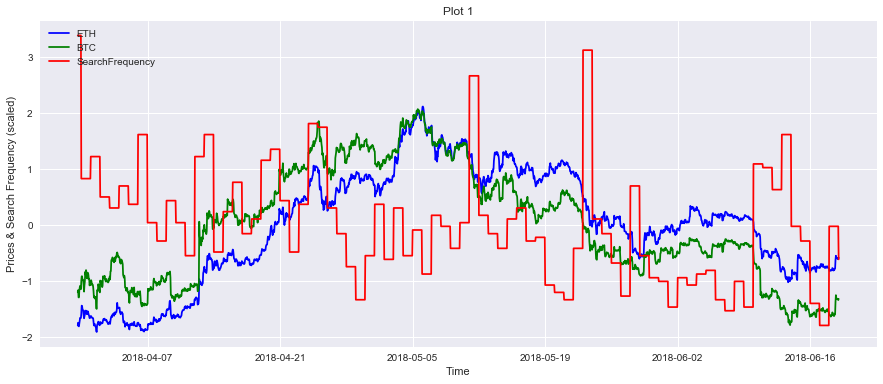

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
#plt.xlim(('2017-07-26', '2017-10-10'))
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 1')
plt.rcParams["figure.figsize"] = (15,6)
plt.show()

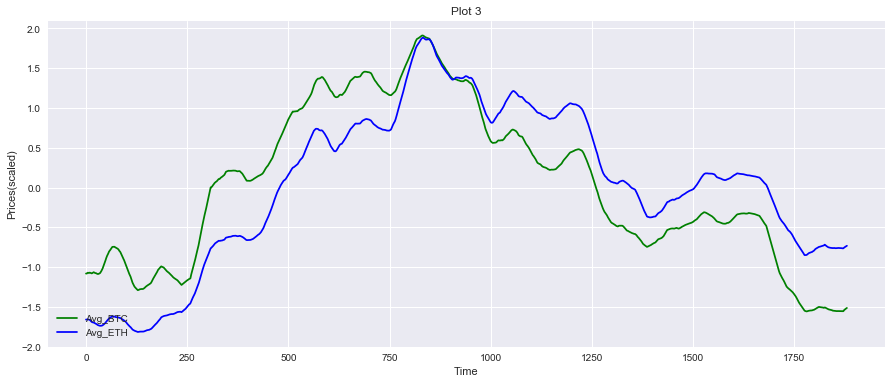

In [21]:
# Plot 3- BTC/ETH moving averages (scaled)
import numpy as np
a = 50
b = a-1
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma_combined = pd.DataFrame()
ma_combined['ETH'] = moving_average(story_combined_scaled['ETH'].values, a)
ma_combined['BTC'] = moving_average(story_combined_scaled['BTC'].values, a)

plt.plot(ma_combined.index, ma_combined['BTC'], color='green', label = 'Avg_BTC')
plt.plot(ma_combined.index, ma_combined['ETH'], color='blue', label = 'Avg_ETH')
plt.legend(loc='lower left')
plt.ylabel('Prices(scaled)')
plt.xlabel('Time')
plt.title('Plot 3')
plt.show()

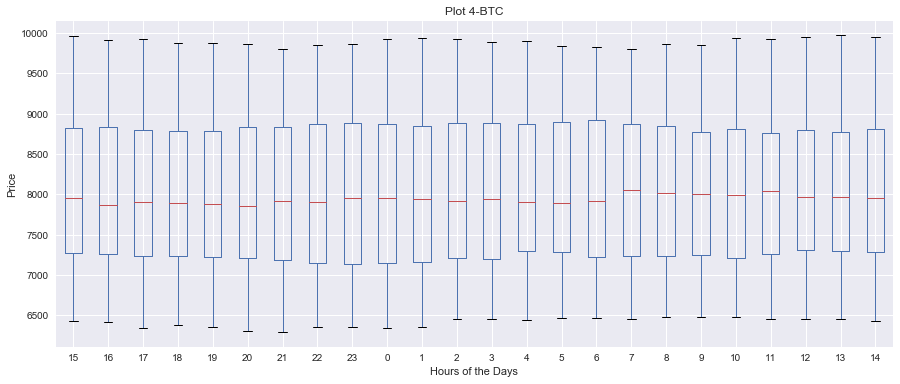

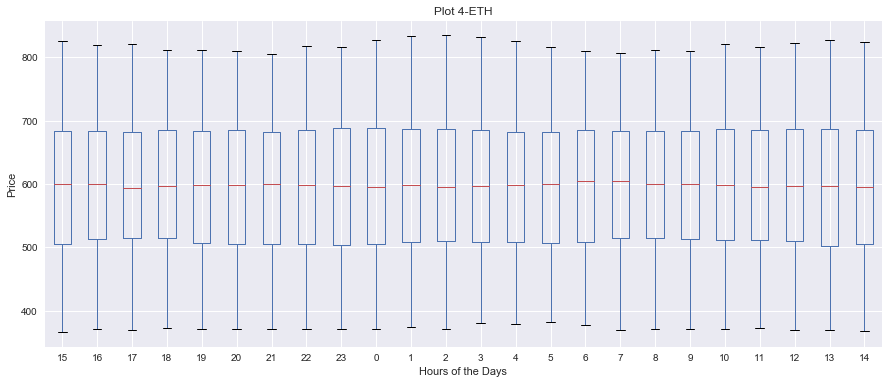

In [22]:
# Plot 4- Box plot by hour of the day

from datetime import datetime, timezone
from collections import OrderedDict
from collections import defaultdict

for coin in story_coin:
    group = OrderedDict.fromkeys(story_combined[coin].index.hour)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.hour].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    hour = pd.DataFrame()
    for key, value in group.items():
        hour[key] = value[:min_len]
    hour.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Hours of the Days')
    plt.title('Plot 4-{}'.format(coin), loc='center')
    plt.show()

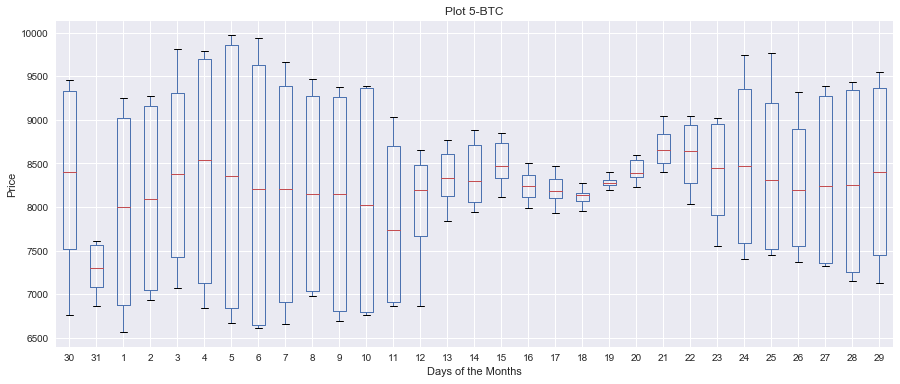

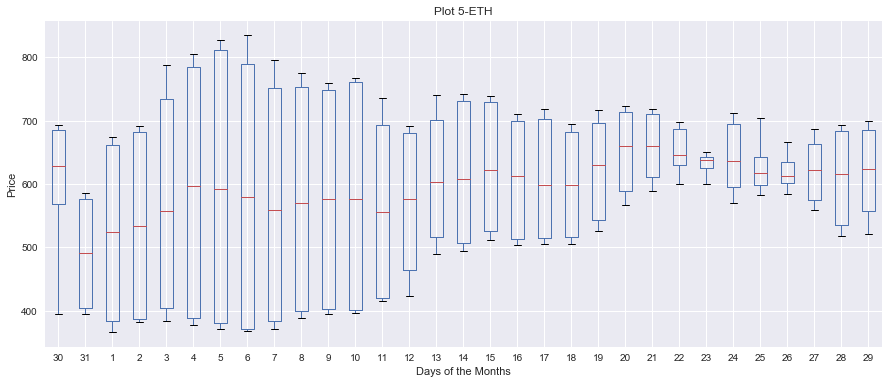

In [23]:
# Plot 5- Box plot by day of the month

for coin in story_coin:    
    group = OrderedDict.fromkeys(story_combined[coin].index.day)
    group = defaultdict(list)
    for i in story_combined[coin].index:
        group[i.day].append(story_combined[coin][i])
    lenght = []
    for key in group:
        lenght.append(len(group[key]))
    min_len = min(lenght)
    day = pd.DataFrame()
    for key, value in group.items():
        day[key] = value[:min_len]
    

    day.boxplot()
    plt.ylabel('Price')
    plt.xlabel('Days of the Months')
    plt.title('Plot 5-{}'.format(coin), loc='center')
    plt.show()

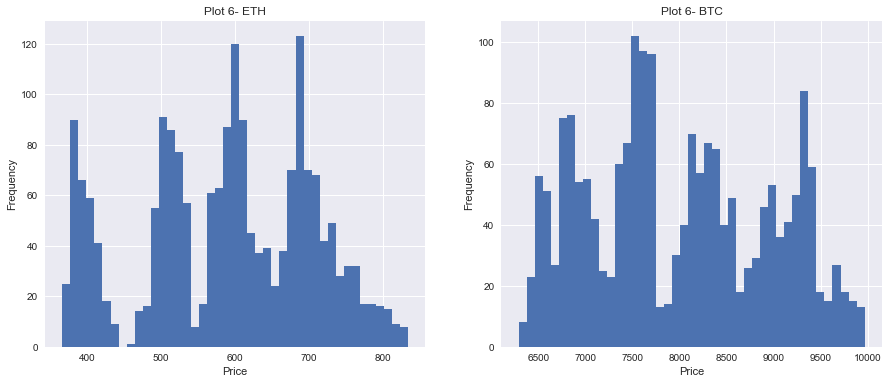

In [24]:
# Plot 6- BTC/ETH histogram

n_data = len(story_combined['ETH'])
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
story_combined['ETH'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 6- ETH', loc='center')
plt.subplot(1, 2, 2)
story_combined['BTC'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Plot 6- BTC', loc='center')
plt.show()

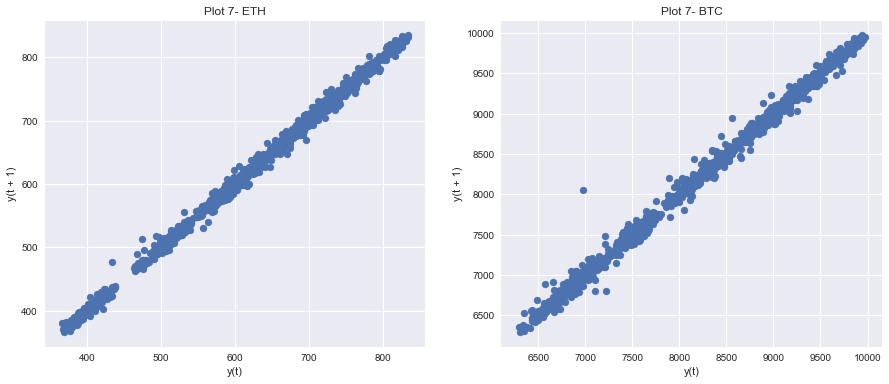

In [25]:
# Plot 7- BTC/ETH lag1 scatter plot

from pandas.plotting import lag_plot
plt.subplot(1, 2, 1)
lag_plot(story_combined['ETH'])
plt.title('Plot 7- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined['BTC'])
plt.title('Plot 7- BTC', loc='center')
plt.show()

In [26]:
# Result 1- Perform Dickey Fuller Test to determine stationality of BTC and ETC time series

from statsmodels.tsa.stattools import adfuller
x = story_combined['ETH'].values
DF_ETH = adfuller(x)
print('\n')
print('\033[1m' + 'Result 1' + '\033[0m')
print('ADF Statistic (ETH): %f' % DF_ETH[0])
print('p-value: %f' % DF_ETH[1])
print('Critical Values:')
for key, value in DF_ETH[4].items():
    print('\t%s: %.3f' % (key, value))

y = story_combined['BTC'].values
DF_BTC = adfuller(y)
print('\n')
print('ADF Statistic (BTC): %f' % DF_BTC[0])
print('p-value: %f' % DF_BTC[1])
print('Critical Values:')
for key, value in DF_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools




Result 1
ADF Statistic (ETH): -1.775850
p-value: 0.392515
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (BTC): -1.259086
p-value: 0.647677
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




In [27]:
# create a differenced series, with default value of lag 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# difference the dataset
diff_BTC = difference(story_combined['BTC'])
diff_ETH = difference(story_combined['ETH'])

diff_2 = difference(story_combined['ETH'], 2)
diff_24 = difference(story_combined['ETH'], 24)


In [28]:
DF_diff_BTC = adfuller(diff_BTC)
print('\n')
print('\033[1m' + 'Result 2' + '\033[0m')
print('ADF Statistic (BTC): %f' % DF_diff_BTC[0])
print('p-value: %f' % DF_diff_BTC[1])
print('Critical Values:')
for key, value in DF_diff_BTC[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
DF_diff_ETH = adfuller(diff_ETH)
print('\n')
print('ADF Statistic (ETH): %f' % DF_diff_ETH[0])
print('p-value: %f' % DF_diff_ETH[1])
print('Critical Values:')
for key, value in DF_diff_ETH[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')



Result 2
ADF Statistic (BTC): -31.994628
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


ADF Statistic (ETH): -30.022862
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568




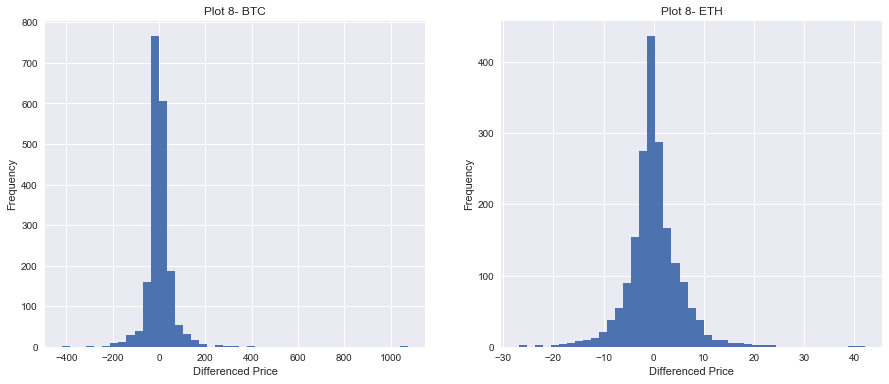

In [29]:
# Plot8- Plotting Histogram of differenced series# Plot8- 

n_data = len(diff_ETH)
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
plt.hist(diff_BTC, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 8- BTC', loc='center')
plt.subplot(1, 2, 2)
plt.hist(diff_ETH, bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Differenced Price')
plt.title('Plot 8- ETH', loc='center')
plt.show()

In [30]:
# Result 3- Perfrom Granger Causality Test with the null hypothesis of ETH doesn't Granger cause BTC
import statsmodels.tsa.stattools as sm
diff_BTC_ETH = pd.DataFrame()
diff_BTC_ETH['BTC'] = diff_BTC
diff_BTC_ETH['ETH'] = diff_ETH
print('Result 3')
cor = sm.grangercausalitytests(diff_BTC_ETH, 30)

Result 3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.0979 , p=0.0000  , df_denom=1925, df_num=1
ssr based chi2 test:   chi2=38.1572 , p=0.0000  , df=1
likelihood ratio test: chi2=37.7846 , p=0.0000  , df=1
parameter F test:         F=38.0979 , p=0.0000  , df_denom=1925, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.8455 , p=0.0000  , df_denom=1922, df_num=2
ssr based chi2 test:   chi2=41.7995 , p=0.0000  , df=2
likelihood ratio test: chi2=41.3526 , p=0.0000  , df=2
parameter F test:         F=20.8455 , p=0.0000  , df_denom=1922, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.9273 , p=0.0000  , df_denom=1919, df_num=3
ssr based chi2 test:   chi2=41.9343 , p=0.0000  , df=3
likelihood ratio test: chi2=41.4843 , p=0.0000  , df=3
parameter F test:         F=13.9273 , p=0.0000  , df_denom=1919, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.68

ssr based F test:         F=2.3756  , p=0.0001  , df_denom=1841, df_num=29
ssr based chi2 test:   chi2=71.1009 , p=0.0000  , df=29
likelihood ratio test: chi2=69.8028 , p=0.0000  , df=29
parameter F test:         F=2.3756  , p=0.0001  , df_denom=1841, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=2.3631  , p=0.0000  , df_denom=1838, df_num=30
ssr based chi2 test:   chi2=73.2462 , p=0.0000  , df=30
likelihood ratio test: chi2=71.8689 , p=0.0000  , df=30
parameter F test:         F=2.3631  , p=0.0000  , df_denom=1838, df_num=30


In [31]:

# Result 4- Perform Granger Causality Test with the null hypothesis of BTC doesn't Granger cause ETH# Result
diff_ETH_BTC = pd.DataFrame()
diff_ETH_BTC['ETH'] = diff_ETH
diff_ETH_BTC['BTC'] = diff_BTC
print('Result 4')
cor = sm.grangercausalitytests(diff_ETH_BTC, 30)

Result 4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9463  , p=0.0049  , df_denom=1925, df_num=1
ssr based chi2 test:   chi2=7.9587  , p=0.0048  , df=1
likelihood ratio test: chi2=7.9423  , p=0.0048  , df=1
parameter F test:         F=7.9463  , p=0.0049  , df_denom=1925, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4496  , p=0.0118  , df_denom=1922, df_num=2
ssr based chi2 test:   chi2=8.9223  , p=0.0115  , df=2
likelihood ratio test: chi2=8.9017  , p=0.0117  , df=2
parameter F test:         F=4.4496  , p=0.0118  , df_denom=1922, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1377  , p=0.0245  , df_denom=1919, df_num=3
ssr based chi2 test:   chi2=9.4476  , p=0.0239  , df=3
likelihood ratio test: chi2=9.4245  , p=0.0241  , df=3
parameter F test:         F=3.1377  , p=0.0245  , df_denom=1919, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.384

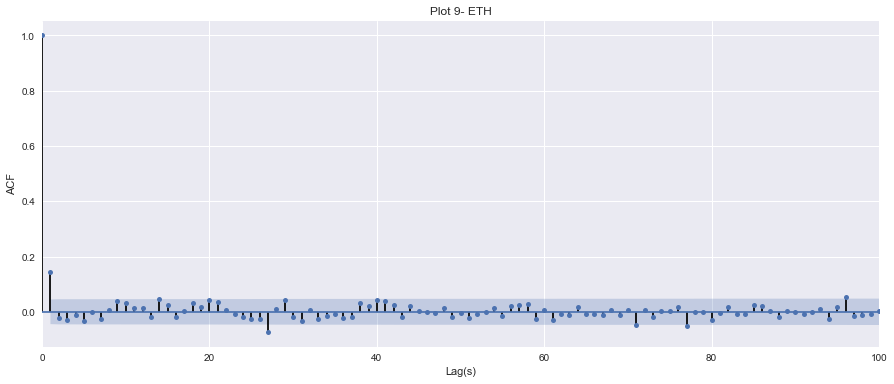

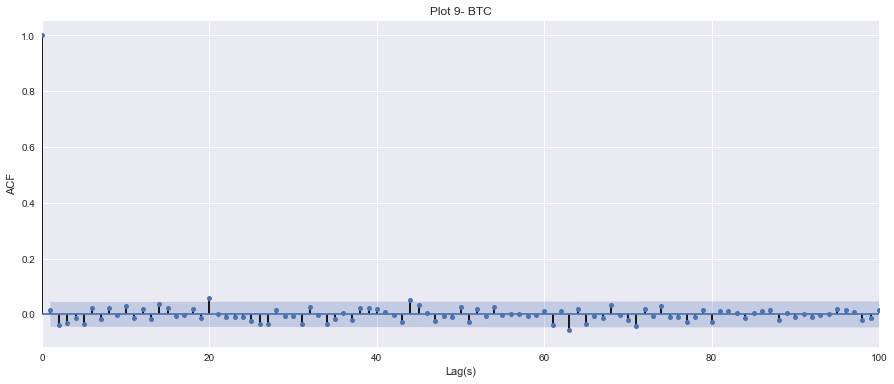

In [32]:
# Plot 9- ACF plot of the differenced series using lag 1 order 1
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
plot_acf(diff_ETH)
plt.title('Plot 9- ETH', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plot_acf(diff_BTC)
plt.title('Plot 9- BTC', loc='center')
plt.xlim((0, 100))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

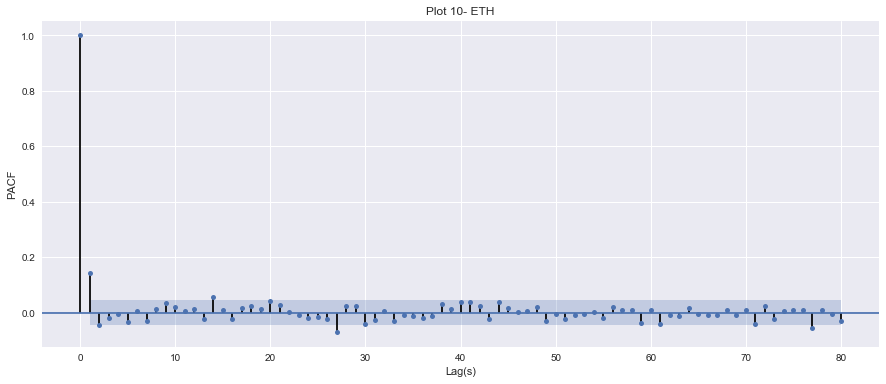

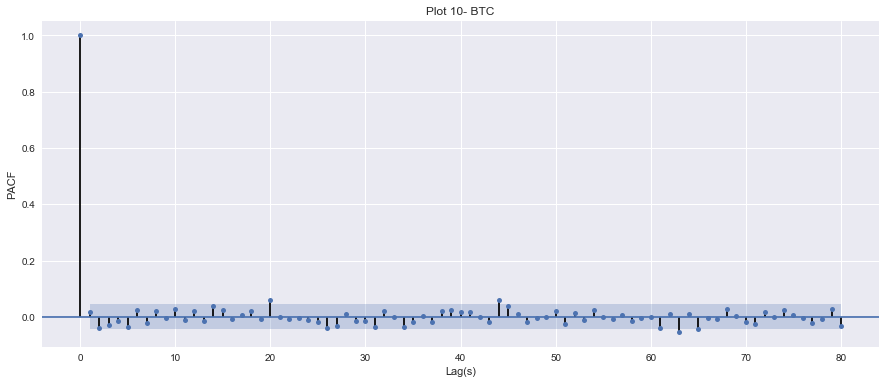

In [33]:
# Plot 10- PACF plot of the differenced series using lag 1 order 1

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff_ETH, lags=80)
plt.title('Plot 10- ETH', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')

plot_pacf(diff_BTC, lags=80)
plt.title('Plot 10- BTC', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()



ADF Statistic: -7.859767
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


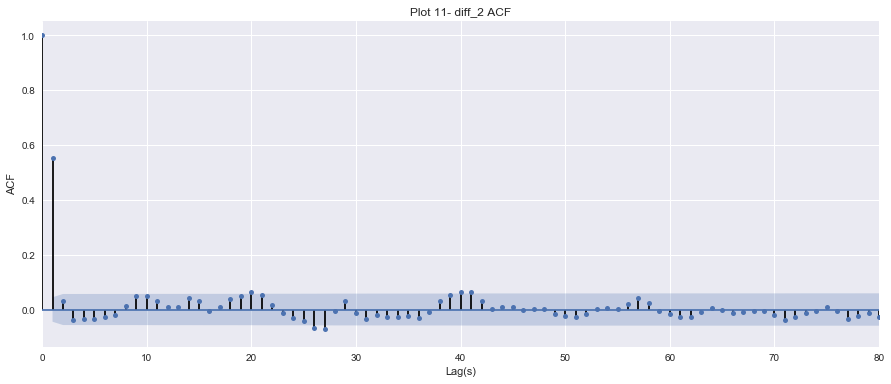

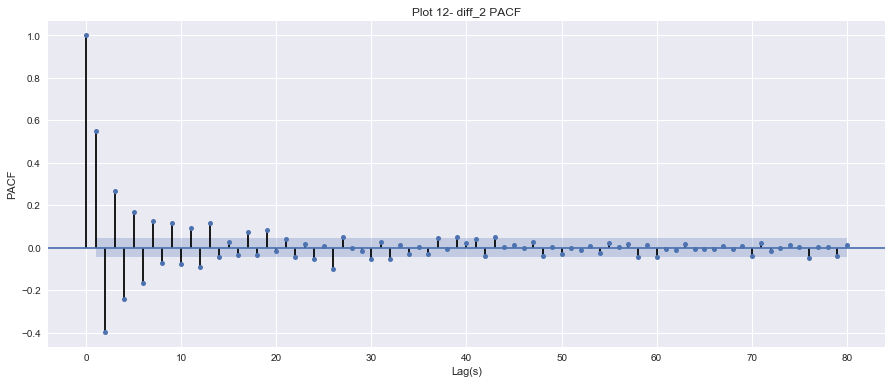

In [34]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using lag 2 order 1# Dickey 

DF_diff_2 = adfuller(diff_2)
print('\n')
print('ADF Statistic: %f' % DF_diff_2[0])
print('p-value: %f' % DF_diff_2[1])
print('Critical Values:')
for key, value in DF_diff_2[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_2)
plt.title('Plot 11- diff_2 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_2, lags=80)
plt.title('Plot 12- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()



ADF Statistic: -5.522307
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


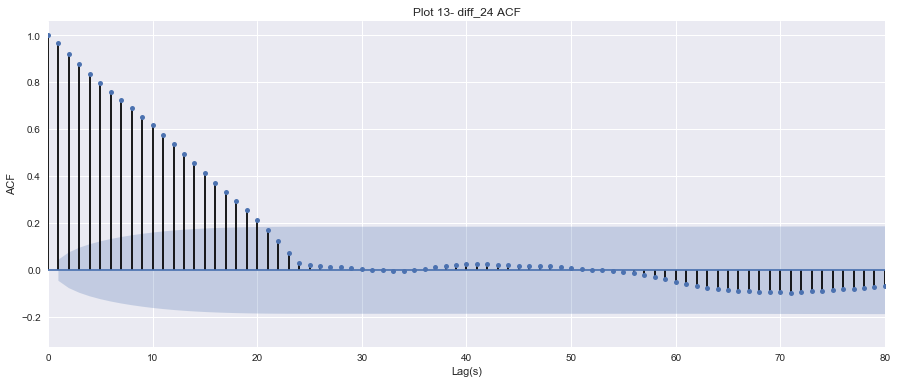

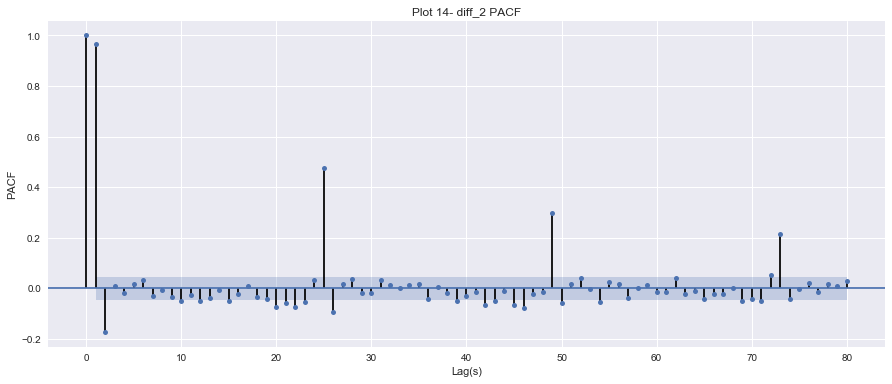

In [35]:
# Dickey Fuller Test result, ACF, and PACF plots of differenced series using lag 2 order 1

DF_diff_24 = adfuller(diff_24)
print('\n')
print('ADF Statistic: %f' % DF_diff_24[0])
print('p-value: %f' % DF_diff_24[1])
print('Critical Values:')
for key, value in DF_diff_24[4].items():
    print('\t%s: %.3f' % (key, value))
    
plot_acf(diff_24)
plt.title('Plot 13- diff_24 ACF', loc='center')
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.xlim([0, 80])
plt.show()

plot_pacf(diff_24, lags=80)
plt.title('Plot 14- diff_2 PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')    
plt.show()

# Getting Data

The following code query and clean the following data: 

1) Top ten cryptocurrency

2) Google News search frequency for the phrase "cryptocurrency"- This data should capture turning point events that affect the crytocurrency markets.

4) Google search frequency for the phrases “Nem wallet download”, “Iota wallet download”, “Nem price”, “Iota price”, “Bitcoin price"- This data should reflect the demand. Original plan was to get the node count (number of wallet in use) or number of wallet software downloaded. However, there was no available API's that provide historical data for this.

5) AMD and Nvidia stock prices- The top 2 semiconductor companies used for coin mining.

6) Google search frequency for the phrase “GPU for mining”- I expect this data to capture the increased demand for coin mining.

In [40]:
import cryptocompare
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime
from pytrends.request import TrendReq
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader
import demjson
import eventregistry
import fix_yahoo_finance as yf


# Login to Google
pytrend = TrendReq()
# Get today date
today_date = datetime.datetime.now().strftime('%Y-%m-%d')

In [41]:
# Getting price data of XEM and IOT using Cryptocompare API# Getti 

# Indicate how many rows of data here
lim = '18000' 
pair = ['BTC', 'ETH','EOS','BCH','ETC','LTC','TRX','QTUM']
coins = pd.DataFrame()
# Making API call, normalize JSON file, and put it in Dataframe
for i in pair:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim 
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time') # Set index
    table.index = pd.to_datetime(table.index ,unit='s') # Make datetime object
    coins = pd.concat([coins, table.high], axis=1)
coins.columns = pair

from_date = coins.index[0].strftime('%Y-%m-%d') # Get date where the query started
to_date = coins.index[-1].strftime('%Y-%m-%d') # Get date where the query ended

In [42]:
print(from_date, to_date)

2018-03-30 2018-06-21


In [46]:
# Query stock data from Morning Star using pandas_datareader

# Specify start and end time here
start = from_date
end = to_date

amd = pandas_datareader.mstar.daily.MorningstarDailyReader('AMD',start= start,end= end)
nvda = pandas_datareader.mstar.daily.MorningstarDailyReader('nvda',start= start,end= end)

# Cleaning and resampling data
amd = amd.read().reset_index(level='Symbol').resample('1h').pad().drop(['Open', 'Low', 'High', 'Symbol', 'Volume'], axis='columns')
nvda = nvda.read().reset_index(level='Symbol').resample('1h').pad().drop(['Open', 'Low', 'High', 'Symbol', 'Volume'], axis='columns')
amd.columns = ['amd']
nvda.columns = ['nvda']
print(amd.head(), nvda.head())

                       amd
Date                      
2018-03-30 00:00:00  10.05
2018-03-30 01:00:00  10.05
2018-03-30 02:00:00  10.05
2018-03-30 03:00:00  10.05
2018-03-30 04:00:00  10.05                        nvda
Date                       
2018-03-30 00:00:00  231.59
2018-03-30 01:00:00  231.59
2018-03-30 02:00:00  231.59
2018-03-30 03:00:00  231.59
2018-03-30 04:00:00  231.59


In [47]:
# Getting data from Google Trends using Pytrends API
 
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe=from_date+' '+today_date) # Build payload
ggtrends_1 = pytrend.interest_over_time()
ggtrends_1 = ggtrends_1.resample('1h').pad().drop(['isPartial'], axis='columns') # Upsample daily to hourly
ggtrends_1.columns = ['gg_crypto']

# keyword = 'nem price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['nem price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_2 = pytrend.interest_over_time()
ggtrends_2 = ggtrends_2.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_2.columns = ['gg_nem_p']

# keyword = 'iota price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['iot price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_3 = pytrend.interest_over_time()
ggtrends_3 = ggtrends_3.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_3.columns = ['gg_iota_p']

# keyword = 'bitcoin price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['bitcoin price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_4 = pytrend.interest_over_time()
ggtrends_4 = ggtrends_4.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_4.columns = ['gg_bitcoin_p']

# keyword = 'nem wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['nem wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_5 = pytrend.interest_over_time()
ggtrends_5 = ggtrends_5.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_5.columns = ['gg_nem_w']

# keyword = 'iota wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['iota wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_6 = pytrend.interest_over_time()
ggtrends_6 = ggtrends_6.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_6.columns = ['gg_iota_w']

# keyword = 'gpu mining', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['gpu mining'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_7 = pytrend.interest_over_time()
ggtrends_7 = ggtrends_7.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_7.columns = ['gg_gpu']

In [49]:
# Joining data frames
df = pd.concat([coins, amd, nvda, ggtrends_1, ggtrends_2, ggtrends_3, ggtrends_4, ggtrends_5, ggtrends_6, ggtrends_7], axis=1).dropna(how='any')
df.to_csv('cap1_df.csv')
print(df.head())

                         BTC     ETH   EOS     BCH    ETC     LTC      TRX  \
time                                                                         
2018-03-30 15:00:00  6851.23  380.11  5.91  689.92  14.36  117.22  0.04168   
2018-03-30 16:00:00  6886.50  385.63  5.95  701.80  14.47  117.09  0.04163   
2018-03-30 17:00:00  6764.61  378.71  5.88  688.16  14.15  115.24  0.04044   
2018-03-30 18:00:00  6762.19  378.06  5.98  687.35  14.23  115.36  0.04082   
2018-03-30 19:00:00  6883.90  383.77  6.01  697.80  14.31  116.73  0.04232   

                      QTUM    amd    nvda  gg_crypto  gg_nem_p  gg_iota_p  \
time                                                                        
2018-03-30 15:00:00  13.89  10.05  231.59      100.0      29.0       16.0   
2018-03-30 16:00:00  14.02  10.05  231.59      100.0      29.0       16.0   
2018-03-30 17:00:00  14.12  10.05  231.59      100.0      29.0       16.0   
2018-03-30 18:00:00  14.20  10.05  231.59      100.0      29.0      

In [50]:
df_scaled = df.copy(deep=True)

sc_x = StandardScaler()
df_scaled = pd.DataFrame(sc_x.fit_transform(df), index=df.index, columns=df.columns)

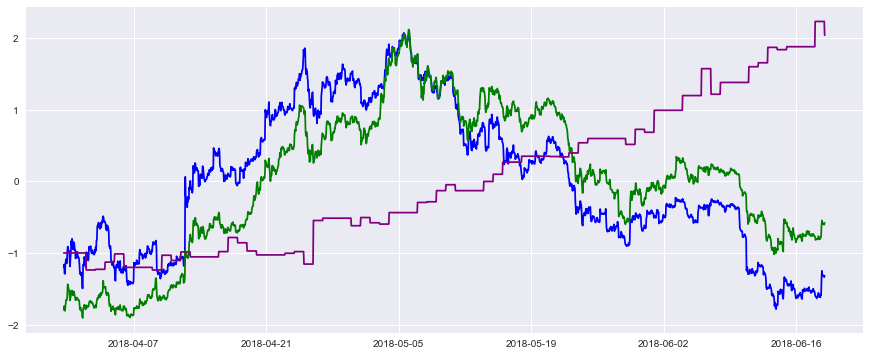

In [51]:
plt.plot(df_scaled.index, df_scaled['BTC'], color='blue')
plt.plot(df_scaled.index, df_scaled['ETH'], color='green')
#plt.plot(df_scaled.index, df_scaled['mc_nem'], color='blue')
#plt.plot(df_scaled.index, df_scaled['mc_iota'], color='blue')
#plt.plot(df_scaled.index, df_scaled['gg_crypto'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_nem_p'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_iota_p'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_bitcoin_p'], color='red')
#plt.plot(df_scaled.index, df_scaled['gg_iota_w'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['gg_nem_w'], color='purple')
#plt.plot(df_scaled.index, df_scaled['gg_gpu'], color='yellow')
plt.plot(df_scaled.index, df_scaled['amd'], color='purple')
#plt.plot(df_scaled.index, df_scaled['nvda'], color='yellow')
#plt.plot(df_scaled.index, df_scaled['rd_CrypCurr_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_nem_g'], color='blue')
#plt.plot(df_scaled.index, df_scaled['rd_Iota_g'], color='blue')
#plt.xlim(('2017-11-01', '2017-10-10'))
plt.show()

In [52]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

In [55]:
# Standardize the data
df = pd.read_csv('cap1_df.csv', index_col='time')
sc_x = StandardScaler()
df_scaled_1 = pd.DataFrame(sc_x.fit_transform(df), index=df.index, columns=df.columns)
df_scaled_1.head()

,BTC,ETH,EOS,BCH,ETC,LTC,TRX,QTUM,amd,nvda,gg_crypto,gg_nem_p,gg_iota_p,gg_bitcoin_p,gg_nem_w,gg_iota_w,gg_gpu
time,,,,,,,,,,,,,,,,,
2018-03-30 15:00:00,-1.198578,-1.790427,-1.630069,-1.309547,-0.914731,-0.739830,-1.060830,-0.604727,-1.000351,-0.688186,3.88399,0.16877,-0.725283,3.185039,-0.939001,0.433631,-0.97284
2018-03-30 16:00:00,-1.161578,-1.742915,-1.619799,-1.270788,-0.878341,-0.746671,-1.063725,-0.568504,-1.000351,-0.688186,3.88399,0.16877,-0.725283,3.185039,-0.939001,0.433631,-0.97284
2018-03-30 17:00:00,-1.289449,-1.802477,-1.637771,-1.315289,-0.984203,-0.844030,-1.132611,-0.540640,-1.000351,-0.688186,3.88399,0.16877,-0.725283,3.185039,-0.939001,0.433631,-0.97284
2018-03-30 18:00:00,-1.291987,-1.808071,-1.612097,-1.317931,-0.957737,-0.837715,-1.110614,-0.518348,-1.000351,-0.688186,3.88399,0.16877,-0.725283,3.185039,-0.939001,0.433631,-0.97284
2018-03-30 19:00:00,-1.164306,-1.758924,-1.604395,-1.283838,-0.931272,-0.765617,-1.023782,-0.565717,-1.000351,-0.688186,3.88399,0.16877,-0.725283,3.185039,-0.939001,0.433631,-0.97284


In [58]:
def difference(dataset, interval=24):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Differencing the dataset
inter_d = 24
df_diff = pd.DataFrame(index=df.index)
for i in df.columns:
    data = difference(df_scaled[i], inter_d)
    data = pd.Series(np.append(np.repeat(np.nan, inter_d), data), index=df.index, name=i)
    df_diff = pd.concat([df_diff, data], ignore_index=False, axis=1)

In [59]:
# Perform Dickey-fuller test to test the differenced series for stationality

diff = df_diff.dropna()

for i in diff.columns: 
    x = diff[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

BTC
ADF Statistic: -5.639331400358972
p-value: 1.0452573903963297e-06
ETH
ADF Statistic: -5.522307402646817
p-value: 1.8657525453988808e-06
EOS
ADF Statistic: -5.976217564841655
p-value: 1.8847850065224514e-07
BCH
ADF Statistic: -6.056195689342121
p-value: 1.2434997166715587e-07
ETC
ADF Statistic: -6.40674716703004
p-value: 1.934832051532709e-08
LTC
ADF Statistic: -5.448310745613991
p-value: 2.6794290070372987e-06
TRX
ADF Statistic: -5.417555994874244
p-value: 3.1111727751770942e-06
QTUM
ADF Statistic: -6.170190454318588
p-value: 6.83495854817111e-08
amd
ADF Statistic: -5.570538918467684
p-value: 1.4709213632199514e-06
nvda
ADF Statistic: -4.957450781979962
p-value: 2.692377777679918e-05
gg_crypto
ADF Statistic: -6.6209045818972
p-value: 6.040707485907071e-09
gg_nem_p
ADF Statistic: -6.1442076283601335
p-value: 7.838394677510563e-08
gg_iota_p
ADF Statistic: -6.791117239165956
p-value: 2.3633378179536805e-09
gg_bitcoin_p
ADF Statistic: -7.029847627472693
p-value: 6.226100002580633e-10
g

In [60]:
# Splitting data to test/train sets# Split 

X = diff[list(df_diff.columns)[1:]]
Ytrain = pd.DataFrame(diff[:1330]['BTC'])
Ytest = pd.DataFrame(diff[1330:]['BTC'])

In [61]:
# Performing ElasticNet Regression 

en = ElasticNet(alpha=0.1, normalize=False)
en.fit(X[:1330], Ytrain)
coef = list(en.coef_)
count = 0
for i in X.columns:
    print(i, ':', coef[count])
    count = count + 1


ETH : 0.0
EOS : 0.0
BCH : 0.0
ETC : 0.052965379246176766
LTC : 0.1858876911883861
TRX : 0.0
QTUM : 0.0375016741866708
amd : -0.0
nvda : -0.0
gg_crypto : -0.0
gg_nem_p : -0.00375229182742678
gg_iota_p : -0.019683644371899428
gg_bitcoin_p : -0.0
gg_nem_w : -0.0
gg_iota_w : 0.0
gg_gpu : -0.0


In [70]:
sig = ['ETC', 'LTC', 'QTUM']
X_sig = X.loc[:,sig]
X_sig.head()

,ETC,LTC,QTUM
time,,,
2018-03-31 15:00:00,0.062855,0.193666,0.111457
2018-03-31 16:00:00,0.082704,0.245240,0.147680
2018-03-31 17:00:00,0.188565,0.349967,0.117030
2018-03-31 18:00:00,0.138943,0.315233,0.072447
2018-03-31 19:00:00,0.079396,0.198402,0.069661


In [71]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sm
import statsmodels.tsa.arima_model as ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [72]:
X_train = X_sig[:1330]
X_test = X_sig[1330:]
X = X_sig
Y_train = pd.DataFrame(diff[:1330]['BTC'])
Y_test = pd.DataFrame(diff[1330:]['BTC'])
Y = pd.DataFrame(diff['BTC'])

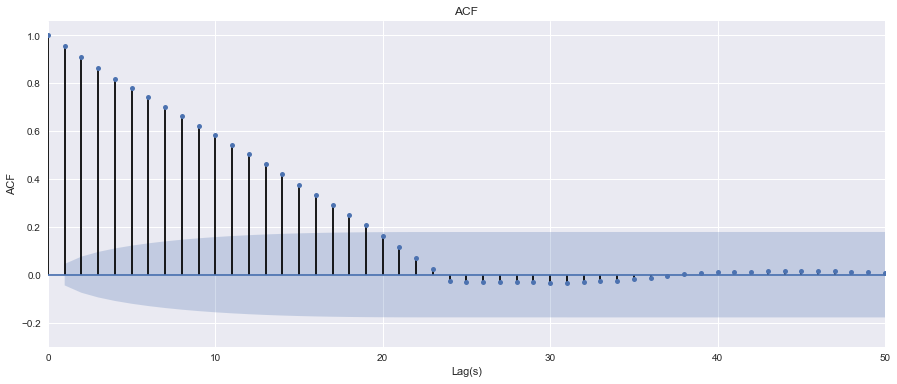

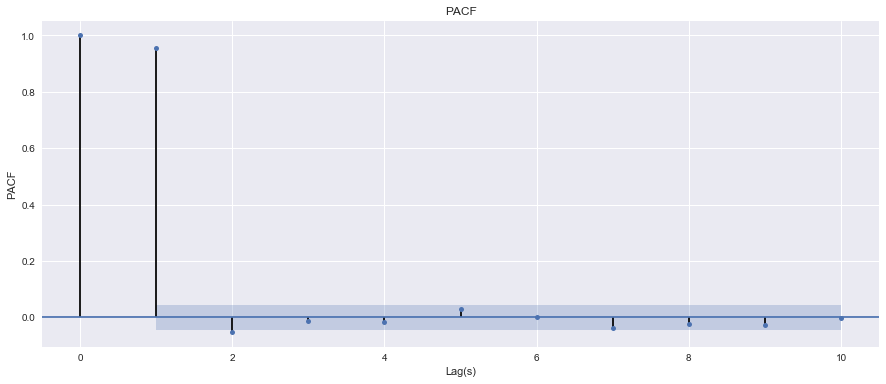

In [73]:
# Plotting ACF and PACF

# ACF
plot_acf(Y)
plt.title('ACF', loc='center')
plt.xlim((0, 50))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

# PACF
plot_pacf(Y, lags=10)
plt.title('PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                    BTC   No. Observations:                 1330
Model:                     ARMA(1, 0)   Log Likelihood                1983.308
Method:                       css-mle   S.D. of innovations              0.054
Date:                Thu, 21 Jun 2018   AIC                          -3954.615
Time:                        19:53:26   BIC                          -3923.458
Sample:                    03-31-2018   HQIC                         -3942.938
                         - 05-26-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0110      0.024      0.448      0.654      -0.037       0.059
ETC            0.1886      0.023      8.032      0.000       0.143       0.235
LTC            0.5581      0.022     25.192      0.0

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


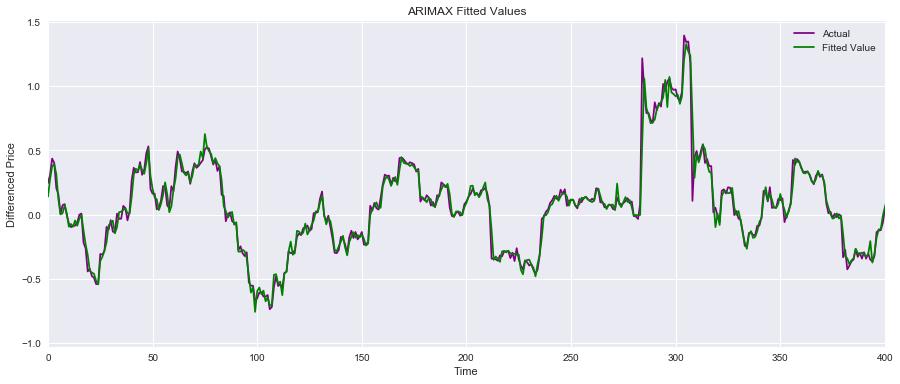

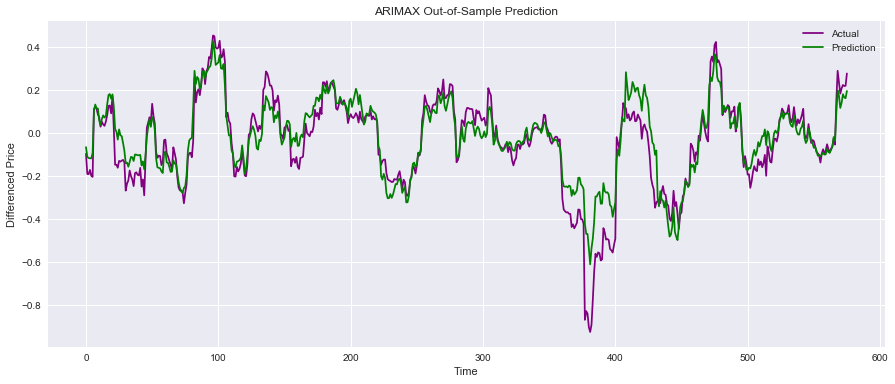

In [74]:
# ARIMAX

# Building AR 1 with exogeneous variables
arima_d = ARIMA.ARIMA(endog=Y_train, exog=X_train, order=[1,0,0])
arima_results_d = arima_d.fit()
print(arima_results_d.summary())

# Plotting the fitted values
plt.plot(np.arange(len(Y_train)), Y_train, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_d.fittedvalues)), arima_results_d.fittedvalues, color='green', label='Fitted Value')
plt.xlim((0, 400))
plt.title('ARIMAX Fitted Values')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

# Out-of-sample prediction
arima_results_ofs_d = arima_results_d.predict(exog=X_test, start=X_test.index[0], end=X_test.index[-1])
plt.plot(np.arange(len(Y_test)), Y_test, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_ofs_d)), arima_results_ofs_d, color='green', label='Prediction')
#plt.xlim((0, 50))
plt.title('ARIMAX Out-of-Sample Prediction')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

In [76]:
# Metric

# Calculating mean squared error for steps 1-100
expected = Y_test[:99]
predictions = arima_results_ofs_d[:99]
mse = mean_squared_error(expected, predictions)
print('Mean Squared Error')
print('Steps 1-100: %f' % mse)

# Calculating mean squred error for steps 101-600
expected = Y_test[100:]
predictions = arima_results_ofs_d[100:]
mse = mean_squared_error(expected, predictions)
print('Steps 101-600: %f' % mse)

Mean Squared Error
Steps 1-100: 0.004460
Steps 101-600: 0.008307
